<a href="https://colab.research.google.com/github/Laeti-dev/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System/blob/master/notebooks/02-training_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Setup

In [1]:
# Mount drive and set path to data
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import userdata
import os
import sys
import shutil

USER = "Laeti-dev"
REPO = "P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System"
TOKEN = userdata.get('GITHUB_TOKEN')
GIT_PATH = f"https://{TOKEN}@github.com/{USER}/{REPO}.git"

# Go to /content/
%cd /content/

# Clone or pull
if not os.path.exists(REPO):
    !git clone {GIT_PATH}
    %cd {REPO}
else:
    %cd {REPO}
    !git config pull.rebase true
    !git pull origin master

%cd /content/{REPO}

# Ensure the data_path_on_drive variable is accessible and correct
data_path_on_drive = f'/content/drive/MyDrive/OC/Projets/P8/'

# Unzip directly into the raw data directory on Google Drive
!unzip -q /content/drive/MyDrive/OC/Projets/P8/data.zip -d {data_path_on_drive}


if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

import src.utils as utils
#%load_ext autoreload
#%autoreload 2

import src.utils as utils
print(f"Images are HERE : {utils.IMAGES_DIR}")

/content
/content/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 957 bytes | 478.00 KiB/s, done.
From https://github.com/Laeti-dev/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System
 * branch            master     -> FETCH_HEAD
   9ab50f2..4499048  master     -> origin/master
Updating 9ab50f2..4499048
Fast-forward
 src/data_generator.py |  8 +++++++-
 src/utils.py          | 31 +++++++++++++++++++++++++++----
 2 files changed, 34 insertions(+), 5 deletions(-)
/content/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System
replace /content/drive/MyDrive/OC/Projets/P8/__MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Images are HERE : /content/drive/MyDrive/OC/Projets/P8/data/raw/leftImg8bit


In [3]:
import os
import shutil

directories_to_delete = [
    "/content/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System",
    "/content/__MACOSX",
    "/content/raw"
]

for directory in directories_to_delete:
    if os.path.exists(directory):
        print(f"Suppression du répertoire : {directory}")
        shutil.rmtree(directory)
        print("Répertoire supprimé avec succès.")
    else:
        print(f"Le répertoire {directory} n'existe pas, pas de suppression nécessaire.")

Le répertoire /content/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System n'existe pas, pas de suppression nécessaire.
Le répertoire /content/__MACOSX n'existe pas, pas de suppression nécessaire.
Le répertoire /content/raw n'existe pas, pas de suppression nécessaire.


In [3]:
# Install requirements
!pip install python-dotenv albumentations --quiet
!pip install mlflow --quiet
!pip install fastparquet --quiet

In [4]:
# Find secrets
try:
    from google.colab import userdata
    COLAB = True
except ImportError:
    COLAB = False

def get_secret(key, default):
    if COLAB:
        try:
            # Get secrets from colab
            return userdata.get(key)
        except userdata.SecretNotFoundError:
            return os.getenv(key)
    else:
        # Get secrets from .env
        from dotenv import load_dotenv
        load_dotenv()
        return os.getenv(key, default)

# Training Pipeline - U-Net for Cityscapes Segmentation

This notebook implements the complete training pipeline for semantic segmentation on the Cityscapes dataset.

## Objectives
- Create and compile the U-Net model
- Set up data generators with augmentation
- Train the model with callbacks
- Visualize predictions during training
- Monitor training metrics
- Save the best model


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import importlib


COLAB = 'google.colab' in sys.modules

if COLAB :
  PROJECT_ROOT = Path("/content/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System")
else:
  # Load environment variables from .env file
  try:
      from dotenv import load_dotenv
      # Try to load .env from project root (parent of notebooks/)
      # In notebooks, we're in notebooks/ directory, so go up one level
      env_path = Path('..') / '.env'
      if env_path.exists():
          load_dotenv(env_path)
          print(f"✓ Loaded environment variables from {env_path.resolve()}")
      else:
          # Try current directory (notebooks/)
          env_path = Path('.env')
          if env_path.exists():
              load_dotenv(env_path)
              print(f"✓ Loaded environment variables from {env_path.resolve()}")
          else:
              # Try project root from absolute path
              import os
              project_root = Path(os.path.abspath('..'))
              env_path = project_root / '.env'
              if env_path.exists():
                  load_dotenv(env_path)
                  print(f"✓ Loaded environment variables from {env_path}")
              else:
                  print("⚠ .env file not found. Make sure it exists in the project root.")
  except ImportError:
      print("⚠ python-dotenv not installed. Install with: pip install python-dotenv")
  except Exception as e:
      print(f"⚠ Could not load .env file: {e}")

module_path = str(PROJECT_ROOT)

if module_path not in sys.path:
    sys.path.insert(0, module_path)
    print(f"✓ Added to sys.path: {module_path}")

# MLflow tracking
try:
    from src.mlflow_tracking import MLflowTracker, setup_mlflow_tracking
    from src.callbacks import MLflowCallback, MLflowVisualizationCallback, MLflowModelCallback
    MLFLOW_AVAILABLE = True
    print("✓ MLflow tracking available")
except ImportError:
    MLFLOW_AVAILABLE = False
    print("⚠ MLflow not available. Install with: pip install mlflow")


# TensorFlow/Keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard
)


from src.model_architecture import build_unet, build_unet_small, build_unet_mobilenet, build_deeplabv3, build_deeplabv3_with_mobilenet
from src.metrics import combined_loss, DiceCoefficient, IoUCoefficient
from src.data_generator import create_data_generators # Now this will pick up updated paths
# from src.augmentations import get_training_augmentation, get_light_augmentation
from src.callbacks import (
    PredictionVisualizationFromGenerator,
    TrainingTimeCallback,
    AzureUploadCallback,
    AzureModelCheckpoint
)
from src.azure_storage import AzureStorageManager

# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)


print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✓ MLflow tracking available
Libraries imported successfully!
TensorFlow version: 2.19.0


In [8]:
import os
import shutil

repo_path = "/content/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System"

if os.path.exists(repo_path):
    print(f"Suppression du répertoire : {repo_path}")
    shutil.rmtree(repo_path)
    print("Répertoire supprimé avec succès.")
else:
    print(f"Le répertoire {repo_path} n'existe pas.")

Suppression du répertoire : /content/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System
Répertoire supprimé avec succès.


## 1. Configuration

Define hyperparameters and training settings.


In [ ]:
# Training configuration
IMAGE_SIZE = (256, 512)  # (height, width)
BATCH_SIZE = 8
N_CLASSES = 8
EPOCHS = 10
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.2

# Model configuration
USE_SMALL_MODEL = False  # Set to True for faster
USE_MOBILENET_BACKBONE = False
USE_DEEPLABV3 = False
USE_DEEPLABV3_WITH_BACKBONE = False
# Validate that only one of the model configuration is True
assert sum([USE_SMALL_MODEL, USE_MOBILENET_BACKBONE, USE_DEEPLABV3, USE_DEEPLABV3_WITH_BACKBONE]) == 1, "Only one model configuration can be True"
INITIAL_FILTERS = 64  # Number of filters in first layer
MOBILENET_ALPHA = 1.0  # MobileNet width multiplier (1.0, 0.75, 0.5, 0.35)
MOBILENET_WEIGHTS = None  # Pre-trained weights: "imagenet" or None
DECODER_FILTERS = 256  # Number of filters in decoder (for MobileNet backbone)

# Augmentation
USE_AUGMENTATION = False
USE_LIGHT_AUGMENTATION = False  # Set to True for faster training

# Callbacks configuration
VISUALIZE_PREDICTIONS = True
VIZ_FREQUENCY = 1  # Visualize every N epochs
EARLY_STOPPING_PATIENCE = 2
REDUCE_LR_PATIENCE = 5

# Paths
IS_COLAB = 'COLAB_GPU' in os.environ or 'COLAB_JUPYTER_IP' in os.environ

if IS_COLAB:
    checkpoint_dir = "/content/drive/MyDrive/OC/Projets/P8/checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    base = data_path_on_drive

    BEST_MODEL_PATH = os.path.join(checkpoint_dir, "best_model.keras")
    LAST_MODEL_PATH = os.path.join(checkpoint_dir, "last_epoch_checkpoint.keras")
else:
    # Chemin local pour Cursor
    checkpoint_dir = "./models/checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    base = ""

    BEST_MODEL_PATH = os.path.join(checkpoint_dir, "best_model.keras")

print(f"Sauvegarde des modèles dans : {checkpoint_dir}")
MODEL_SAVE_PATH = f"{base}models"
OUTPUT_DIR = f"{base}outputs/training_visualizations"
LOGS_DIR = f"{base}logs"

# Azure Storage configuration
USE_AZURE_STORAGE = False  # Set to True to enable Azure uploads
AZURE_CONTAINER_NAME = "training-outputs"
AZURE_RUN_NAME = "MobileNetV2"  # Optional: name for this training run (e.g., "experiment_001")
AZURE_UPLOAD_FREQUENCY = 1  # Upload every N epochs (1 = every epoch)
AZURE_ONLY_MODE = True  # Set to True to save ONLY to Azure (no local saves)
AZURE_CREATE_CONTAINER = False  # Set to True to auto-create container (requires permissions)
                                 # If False, container must exist already

# MLflow configuration
USE_MLFLOW = True  # Set to True to enable MLflow tracking
mlflow_tracker = None

if USE_MLFLOW:
  if "google.colab" in sys.modules:
    try:
            DAGSHUB_USER = userdata.get('DAGSHUB_USERNAME')
            if DAGSHUB_USER:
                DAGSHUB_USER = DAGSHUB_USER.replace('\r', '').replace('\n', '').strip() # Aggressively clean
            DAGSHUB_TOKEN = userdata.get('DAGSHUB_TOKEN')
            DAGSHUB_REPO = userdata.get('DAGSHUB_REPO_NAME')
            if DAGSHUB_REPO:
                DAGSHUB_REPO = DAGSHUB_REPO.replace('\r', '').replace('\n', '').strip() # Aggressively clean

            os.environ['MLFLOW_TRACKING_USERNAME'] = DAGSHUB_USER
            os.environ['MLFLOW_TRACKING_PASSWORD'] = DAGSHUB_TOKEN

            MLFLOW_TRACKING_URI = f"https://dagshub.com/{DAGSHUB_USER}/{DAGSHUB_REPO}.mlflow"
            print(f"✓ DagsHub configuration detected for Colab")

    except Exception as e:
            print(f"⚠ Erreur Secrets Colab : {e}. Repli sur localhost.")
            MLFLOW_TRACKING_URI = 'http://localhost:5001'
  else:
    # MLflow configuration from environment variables
    MLFLOW_TRACKING_URI = get_secret('MLFLOW_TRACKING_URI', 'http://localhost:5001')

if MLFLOW_TRACKING_URI and ' ' in MLFLOW_TRACKING_URI:
    MLFLOW_TRACKING_URI = MLFLOW_TRACKING_URI.split(' ')[0]
MLFLOW_EXPERIMENT_NAME = get_secret('MLFLOW_EXPERIMENT_NAME', 'unet_cityscapes_segmentation')
if MLFLOW_EXPERIMENT_NAME:
    MLFLOW_EXPERIMENT_NAME = MLFLOW_EXPERIMENT_NAME.replace('\r', '').replace('\n', '').strip()

# Create directories
Path("models").mkdir(exist_ok=True)
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(LOGS_DIR).mkdir(exist_ok=True)

print("Configuration:")
print(f"  Image size: {IMAGE_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
if USE_MOBILENET_BACKBONE:
    print(f"  Model: U-Net with MobileNetV2 backbone (alpha={MOBILENET_ALPHA})")
elif USE_DEEPLABV3:
    print(f"  Model: DeepLabV3")
elif USE_DEEPLABV3_WITH_BACKBONE:
    print(f"  Model: DeepLabV3 with MobileNetV2 backbone")
else:
    print(f"  Model: {'Small' if USE_SMALL_MODEL else 'Full'} U-Net")
print(f"  Augmentation: {'Light' if USE_LIGHT_AUGMENTATION else 'Full' if USE_AUGMENTATION else 'None'}")
print(f"  Azure Storage: {'Enabled' if USE_AZURE_STORAGE else 'Disabled'}")
if USE_AZURE_STORAGE:
    print(f"    Container: {AZURE_CONTAINER_NAME}")
    print(f"    Run name: {AZURE_RUN_NAME or 'default'}")
    print(f"    Upload frequency: every {AZURE_UPLOAD_FREQUENCY} epoch(s)")
    print(f"    Azure-only mode: {'Yes (no local saves)' if AZURE_ONLY_MODE else 'No (local + Azure)'}")
    print(f"    Auto-create container: {'Yes' if AZURE_CREATE_CONTAINER else 'No (must exist)'}")
if USE_MLFLOW and MLFLOW_AVAILABLE:
    # Initialize MLflow tracking
    mlflow_tracker = setup_mlflow_tracking(
        tracking_uri=MLFLOW_TRACKING_URI,
        experiment_name=MLFLOW_EXPERIMENT_NAME
    )
    print("✓ MLflow experiment tracking enabled")
    print(f"    MLflow tracking URI: {MLFLOW_TRACKING_URI}")
    print(f"    MLflow experiment name: {MLFLOW_EXPERIMENT_NAME}")
else:
    print("⚠ MLflow not available. Install with: pip install mlflow")
    print(f"Experiment : {MLFLOW_EXPERIMENT_NAME}")
    print(f"Tracking URI: {MLFLOW_TRACKING_URI}")

Sauvegarde des modèles dans : /content/drive/MyDrive/OC/Projets/P8/checkpoints
✓ DagsHub configuration detected for Colab
Configuration:
  Image size: (256, 512)
  Batch size: 8
  Epochs: 10
  Learning rate: 0.0001
  Model: Full U-Net
  Augmentation: None
  Azure Storage: Disabled
✓ Using existing MLflow experiment: segmentation-U-Net-20e
✓ MLflow experiment tracking enabled
    MLflow tracking URI: https://dagshub.com/Laeti-dev/P8-Image-Processing.mlflow
    MLflow experiment name: segmentation-U-Net-20e


## 2. Create Data Generators

Set up training and validation data generators with optional augmentation.


In [ ]:
# Create augmentation pipeline
if USE_AUGMENTATION:
    # if USE_LIGHT_AUGMENTATION:
    #     train_aug = get_light_augmentation(image_size=IMAGE_SIZE)
    #     print("Using light augmentation")
    # else:
    #     train_aug = get_training_augmentation(image_size=IMAGE_SIZE)
    #     print("Using full augmentation")
    pass
else:
    train_aug = None
    print("No augmentation")

# Create data generators
print("\nCreating data generators...")

# Ensure src.utils paths are set correctly for the data generator
# The zip file structure is data/raw/leftImg8bit and data/raw/gtFine
# data_path_on_drive is defined in MLm_jVuSB17J as '/content/drive/MyDrive/OC/Projets/P8/'
# It should be accessible here.
# Note: Since utils.py now correctly uses data/raw structure, this override ensures Path objects are used
if 'data_path_on_drive' in globals() and os.path.exists(data_path_on_drive):
    from pathlib import Path
    utils.IMAGES_DIR = Path(data_path_on_drive) / 'data' / 'raw' / 'leftImg8bit'
    utils.MASKS_DIR = Path(data_path_on_drive) / 'data' / 'raw' / 'gtFine'
    print(f"Overriding utils.IMAGES_DIR to: {utils.IMAGES_DIR}")
    print(f"Overriding utils.MASKS_DIR to: {utils.MASKS_DIR}")
else:
    print("Warning: data_path_on_drive not found or invalid. Using default utils paths.")

train_gen, val_gen = create_data_generators(
    batch_size=BATCH_SIZE,
    dim=IMAGE_SIZE,
    augmentation=train_aug,
    normalize=True,
    validation_split=VALIDATION_SPLIT,
    max_samples=None  # Use all data, or set a limit (e.g., 1000) for testing
)

print(f"\nData generators created:")
print(f"  Training batches per epoch: {len(train_gen)}")
print(f"  Validation batches per epoch: {len(val_gen)}")
print(f"  Samples per batch: {BATCH_SIZE}")

No augmentation

Creating data generators...
Overriding utils.IMAGES_DIR to: /content/drive/MyDrive/OC/Projets/P8/raw/leftImg8bit
Overriding utils.GT_FINE_DIR to: /content/drive/MyDrive/OC/Projets/P8/raw/gtFine
Total samples used: 191
Training samples: 152
Validation samples: 39

Data generators created:
  Training batches per epoch: 19
  Validation batches per epoch: 4
  Samples per batch: 8


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 3. Test Data Generator

Let's verify that the data generator works correctly by visualizing a batch.


Error loading sample (bochum, 0, 15645): [Errno 2] No such file or directory: '/content/drive/MyDrive/OC/Projets/P8/raw/leftImg8bit/train/bochum/bochum_000000_015645_leftImg8bit.png'
Error loading sample (ulm, 82, 19): [Errno 2] No such file or directory: '/content/drive/MyDrive/OC/Projets/P8/raw/leftImg8bit/train/ulm/ulm_000082_000019_leftImg8bit.png'
Error loading sample (bochum, 0, 24196): [Errno 2] No such file or directory: '/content/drive/MyDrive/OC/Projets/P8/raw/leftImg8bit/train/bochum/bochum_000000_024196_leftImg8bit.png'
Error loading sample (bochum, 0, 14658): [Errno 2] No such file or directory: '/content/drive/MyDrive/OC/Projets/P8/raw/leftImg8bit/train/bochum/bochum_000000_014658_leftImg8bit.png'
Error loading sample (ulm, 19, 19): [Errno 2] No such file or directory: '/content/drive/MyDrive/OC/Projets/P8/raw/leftImg8bit/train/ulm/ulm_000019_000019_leftImg8bit.png'
Error loading sample (ulm, 44, 19): [Errno 2] No such file or directory: '/content/drive/MyDrive/OC/Projets

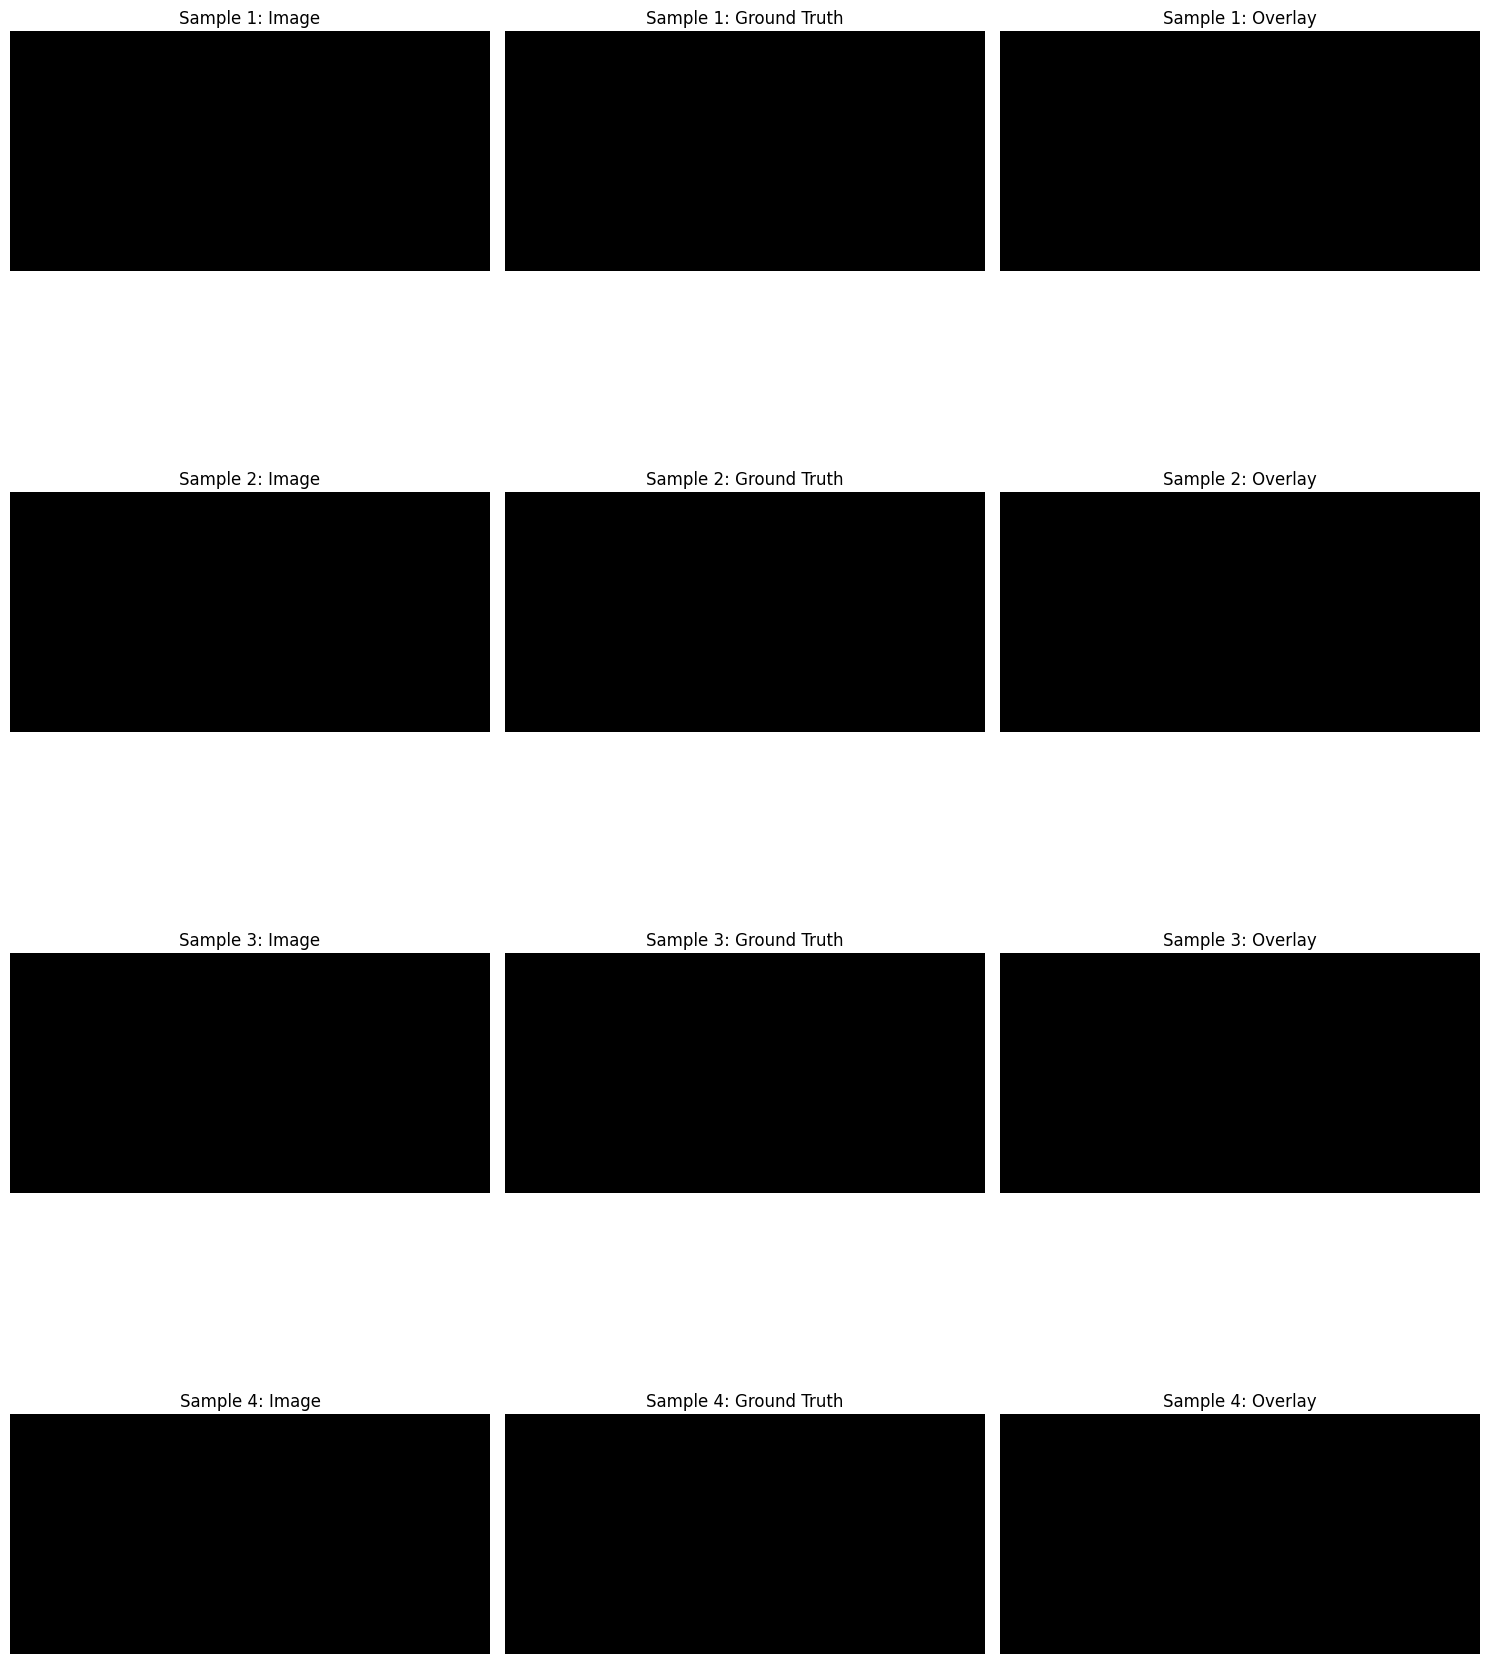

Data generator test successful!


In [8]:
# Test the data generator
from src.utils import mask_to_colored

# Get a batch
images, masks = train_gen[0]

print(f"Batch shape - Images: {images.shape}, Masks: {masks.shape}")
print(f"Image dtype: {images.dtype}, range: [{images.min():.2f}, {images.max():.2f}]")
print(f"Mask dtype: {masks.dtype}, unique values: {np.unique(masks)}")

# Visualize a few samples
n_samples = min(4, len(images))
fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5 * n_samples))

if n_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(n_samples):
    # Denormalize image
    img = (images[i] * 255).astype(np.uint8) if images[i].max() <= 1.0 else images[i].astype(np.uint8)
    mask = masks[i].astype(np.uint8)
    colored_mask = mask_to_colored(mask)

    # Original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Sample {i+1}: Image")
    axes[i, 0].axis('off')

    # Ground truth mask
    axes[i, 1].imshow(colored_mask)
    axes[i, 1].set_title(f"Sample {i+1}: Ground Truth")
    axes[i, 1].axis('off')

    # Overlay
    overlay = (img * 0.6 + colored_mask * 0.4).astype(np.uint8)
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f"Sample {i+1}: Overlay")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
print("Data generator test successful!")


## 4. Build and Compile Model

Create the U-Net architecture and compile it with loss and metrics.


In [ ]:
# Build model
print("Building model...")
if USE_MOBILENET_BACKBONE:
    model = build_unet_mobilenet(
        input_shape=(*IMAGE_SIZE, 3),
        n_classes=N_CLASSES,
        alpha=MOBILENET_ALPHA,
        weights=MOBILENET_WEIGHTS,
        decoder_filters=DECODER_FILTERS
    )
    print(f"Using U-Net with MobileNetV2 backbone (alpha={MOBILENET_ALPHA})")
elif USE_SMALL_MODEL:
    model = build_unet_small(
        input_shape=(*IMAGE_SIZE, 3),
        n_classes=N_CLASSES,
        filters=32
    )
    print("Using small U-Net model")
elif USE_DEEPLABV3:
    model = build_deeplabv3(
        input_shape=(*IMAGE_SIZE, 3),
        n_classes=N_CLASSES,
        filters=INITIAL_FILTERS
    )
    print("Using DeepLabV3 model")
elif USE_DEEPLABV3_WITH_BACKBONE:
    model = build_deeplabv3_with_mobilenet(
        input_shape=(*IMAGE_SIZE, 3),
        n_classes=N_CLASSES,
        filters=INITIAL_FILTERS
    )
    print("Using DeepLabV3 with MobileNetV2 backbone model")
else:
    model = build_unet(
        input_shape=(*IMAGE_SIZE, 3),
        n_classes=N_CLASSES,
        filters=INITIAL_FILTERS,
        alpha=MOBILENET_ALPHA,
        weights=MOBILENET_WEIGHTS
    )
    print("Using full U-Net model")

# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=combined_loss,
    metrics=[
        'accuracy',
        DiceCoefficient(),
        IoUCoefficient()
    ]
)

print(f"Model output shape: {model.output.shape}")

print("\nModel compiled successfully!")
print(f"\nModel summary:")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")


Building model...
Using full U-Net model
Model output shape: (None, 256, 512, 8)

Model compiled successfully!

Model summary:


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 256, 512,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │        256 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_72       │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 256, 512,  │     36,928 │ activation_72[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │        256 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 128, 256,  │          0 │ activation_73[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 128, 256,  │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        512 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_74       │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 128, 256,  │    147,584 │ activation_74[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        512 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_75       │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 64, 128,   │          0 │ activation_75[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 64, 128,   │    295,168 │ max_pooling2d_17… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │      1,024 │ conv2d_80[0][0] 

 Total params: 31,055,752 (118.47 MB)

 Trainable params: 31,043,976 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)


Total parameters: 31,055,752


## 5.MLFLOW Setup

- Initialize MLflow tracker
- Start run with dynamic name
- Log configuration
- Display connexion informations

In [41]:
from datetime import datetime

if USE_MLFLOW and mlflow_tracker:
    # Start MLflow run
    run_name = f"UNet_MobileNetV2_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    mlflow_tracker.start_run(run_name=run_name)

    # Log configuration parameters
    mlflow_tracker.log_params({
        "image_size": str(IMAGE_SIZE),
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE,
        "model_type": "MobileNetV2" if USE_MOBILENET_BACKBONE else "SmallUNet",
        "mobilenet_alpha": MOBILENET_ALPHA,
        "augmentation": "Light" if USE_LIGHT_AUGMENTATION else "Full" if USE_AUGMENTATION else "None"
    })

    # Log system info
    mlflow_tracker.log_system_info()
else:
    print("MLflow tracking is disabled or tracker not initialized.")

MLflow tracking is disabled or tracker not initialized.


## 6. Set Up Callbacks

Configure callbacks for model checkpointing, early stopping, learning rate reduction, and visualization.


In [42]:
IS_COLAB = 'COLAB_GPU' in os.environ or 'COLAB_JUPYTER_IP' in os.environ
# Create callbacks list
callbacks = []

# Model checkpoint - save best model
if USE_AZURE_STORAGE and AZURE_ONLY_MODE:
    # Save directly to Azure only (no local save)
    try:
        azure_manager = AzureStorageManager(
            container_name=AZURE_CONTAINER_NAME,
            create_container_if_not_exists=AZURE_CREATE_CONTAINER
        )
        from pathlib import Path
        model_blob_name = f"model/{Path(MODEL_SAVE_PATH).name}"
        azure_checkpoint = AzureModelCheckpoint(
            azure_manager=azure_manager,
            blob_name=model_blob_name,
            monitor='val_iou_coefficient',
            save_best_only=True,
            mode='max',
            verbose=1,
            run_name=AZURE_RUN_NAME
        )
        callbacks.append(azure_checkpoint)
        print("Using Azure-only model checkpoint (no local saves)")
    except Exception as e:
        print(f"Warning: Failed to initialize Azure checkpoint: {e}")
        print("Falling back to local checkpoint...")
        callbacks.append(
            ModelCheckpoint(
                BEST_MODEL_PATH,
                monitor='val_iou_coefficient',
                save_best_only=True,
                mode='max',
                verbose=1,
                save_weights_only=False
            )
        )
else:
    # Save locally (and optionally upload to Azure later)
    callbacks.append(
        ModelCheckpoint(
            BEST_MODEL_PATH,
            monitor='val_iou_coefficient',
            save_best_only=True,
            mode='max',
            verbose=1,
            save_weights_only=False
        )
    )
    if IS_COLAB:
      callbacks.append(
        ModelCheckpoint(
            LAST_MODEL_PATH,
            monitor='val_iou_coefficient',
            save_best_only=False,
            verbose=0,
        )
    )

# Early stopping
callbacks.append(
    EarlyStopping(
        monitor='val_iou_coefficient',
        patience=EARLY_STOPPING_PATIENCE,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
)

# Reduce learning rate on plateau
callbacks.append(
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=REDUCE_LR_PATIENCE,
        min_lr=1e-7,
        verbose=1
    )
)

# TensorBoard
callbacks.append(
    TensorBoard(
        log_dir=LOGS_DIR,
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    )
)

# Training time tracking callback
time_callback = TrainingTimeCallback()
callbacks.append(time_callback)

# Prediction visualization callback
if VISUALIZE_PREDICTIONS:
    viz_callback = PredictionVisualizationFromGenerator(
        validation_generator=val_gen,
        output_dir=OUTPUT_DIR,
        num_samples=4,
        frequency=VIZ_FREQUENCY
    )
    callbacks.append(viz_callback)
    print(f"Visualization callback added (every {VIZ_FREQUENCY} epochs)")

# Azure Storage upload callback
# Only add if not in Azure-only mode (in Azure-only mode, checkpoints are already saved to Azure)
if USE_AZURE_STORAGE and not AZURE_ONLY_MODE:
    try:
        azure_manager = AzureStorageManager(
            container_name=AZURE_CONTAINER_NAME,
            create_container_if_not_exists=AZURE_CREATE_CONTAINER
        )
        azure_callback = AzureUploadCallback(
            azure_manager=azure_manager,
            model_path=MODEL_SAVE_PATH,
            output_dir=OUTPUT_DIR,
            logs_dir=LOGS_DIR,
            run_name=AZURE_RUN_NAME,
            upload_frequency=AZURE_UPLOAD_FREQUENCY
        )
        callbacks.append(azure_callback)
        print(f"Azure upload callback added (every {AZURE_UPLOAD_FREQUENCY} epoch(s))")
    except Exception as e:
        print(f"Warning: Failed to initialize Azure Storage: {e}")
        print("Continuing without Azure upload...")
elif USE_AZURE_STORAGE and AZURE_ONLY_MODE:
    # In Azure-only mode, still upload outputs and logs (but not model, already handled)
    try:
        azure_manager = AzureStorageManager(
            container_name=AZURE_CONTAINER_NAME,
            create_container_if_not_exists=AZURE_CREATE_CONTAINER
        )
        azure_callback = AzureUploadCallback(
            azure_manager=azure_manager,
            model_path=None,  # Model already saved by AzureModelCheckpoint
            output_dir=OUTPUT_DIR,
            logs_dir=LOGS_DIR,
            run_name=AZURE_RUN_NAME,
            upload_frequency=AZURE_UPLOAD_FREQUENCY
        )
        callbacks.append(azure_callback)
        print(f"Azure upload callback added for outputs/logs (every {AZURE_UPLOAD_FREQUENCY} epoch(s))")
    except Exception as e:
        print(f"Warning: Failed to initialize Azure Storage: {e}")
        print("Continuing without Azure upload...")

if USE_MLFLOW and mlflow_tracker and MLFLOW_AVAILABLE:
    # Main metrics callback
    callbacks.append(MLflowCallback(tracker=mlflow_tracker))

    # Visualization callback for MLflow
    if VISUALIZE_PREDICTIONS:
        callbacks.append(MLflowVisualizationCallback(
            mlflow_tracker=mlflow_tracker,
            visualization_dir=OUTPUT_DIR
        ))

    # Model logging callback - MODIFIED TO EXPLICITLY SAVE .keras FILE
    # Using a custom class to avoid the MLflow/Keras 3 direct log_model incompatibility
    class CustomMLflowModelCallback(MLflowModelCallback):
        def on_train_end(self, logs=None):
            import os
            import tempfile
            import mlflow
            from mlflow import log_artifact

            if self.save_model_at_end:
                # Create a temporary file path with .keras extension
                with tempfile.TemporaryDirectory() as tmpdir:
                    temp_model_path = os.path.join(tmpdir, f"{self.model_name}.keras")
                    self.model.save(temp_model_path)
                    print(f"✓ Model saved temporarily to {temp_model_path}")

                    # Log the temporary .keras file as an artifact
                    log_artifact(temp_model_path, artifact_path=self.model_name)
                    print(f"✓ Logged model '{self.model_name}.keras' to MLflow")
            # Ensure the original on_train_end of the parent MLflowCallback is not called if it exists
            # to prevent double logging or conflicts.

    callbacks.append(CustomMLflowModelCallback(
        mlflow_tracker=mlflow_tracker,
        model_name="unet_mobilenet_cityscapes"
    ))
    print("✓ MLflow callbacks added")

print(f"\nTotal callbacks: {len(callbacks)}")
print("Callbacks configured:")
for i, cb in enumerate(callbacks, 1):
    print(f"  {i}. {cb.__class__.__name__}")

Visualization callback initialized (from generator):
  - Output directory: outputs/training_visualizations
  - Number of samples: 4
  - Frequency: every 1 epochs
Visualization callback added (every 1 epochs)

Total callbacks: 7
Callbacks configured:
  1. ModelCheckpoint
  2. ModelCheckpoint
  3. EarlyStopping
  4. ReduceLROnPlateau
  5. TensorBoard
  6. TrainingTimeCallback
  7. PredictionVisualizationFromGenerator


## 6. Train the Model

Start the training process. The model will automatically:
- Save the best model based on validation IoU
- Stop early if no improvement
- Reduce learning rate when plateau is reached
- Visualize predictions periodically
- When using Google colab, save the last model as a checkpoint.


In [43]:
# Train the model
print("Starting training...")
print("=" * 60)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


# End MLflow run
if USE_MLFLOW and mlflow_tracker:
    mlflow_tracker.end_run()
print("=" * 60)
print("Training completed!")
print(f"\nBest model saved to: {MODEL_SAVE_PATH}")
if VISUALIZE_PREDICTIONS:
    print(f"Visualizations saved to: {OUTPUT_DIR}/")
print(f"TensorBoard logs saved to: {LOGS_DIR}/")


Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training time tracking started
Epoch 1/3
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2574 - dice_coefficient: 0.1676 - iou_coefficient: 0.0925 - loss: 1.4858
Epoch 1: val_iou_coefficient improved from -inf to 0.06500, saving model to /content/drive/MyDrive/OC/Projets/P8/checkpoints/best_model.keras
  Saved visualization: outputs/training_visualizations/epoch_001.png
19/19 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.2627 - dice_coefficient: 0.1703 - iou_coefficient: 0.0942 - loss: 1.4785 - val_accuracy: 0.0692 - val_dice_coefficient: 0.1220 - val_iou_coefficient: 0.0650 - val_loss: 1.5430 - learning_rate: 1.0000e-04 - epoch_time: 130.7181 - total_training_time: 130.7181 - avg_epoch_time: 130.7181
Epoch 2/3
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5553 - dice_coefficient: 0.3757 - iou_coefficient: 0.2324 - loss: 1.0170
Epoch 2: val_iou_coefficient improved from 0.06500 to 0.09579, saving model to /content/drive/MyDrive/OC/Projets/P8/checkpoints/best_model.keras
  S

## 7. Visualize Training History

Plot training curves to analyze model performance.


In [1]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Dice Coefficient
axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice')
axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice')
axes[1, 0].set_title('Dice Coefficient')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice')
axes[1, 0].legend()
axes[1, 0].grid(True)

# IoU Coefficient
axes[1, 1].plot(history.history['iou_coefficient'], label='Training IoU')
axes[1, 1].plot(history.history['val_iou_coefficient'], label='Validation IoU')
axes[1, 1].set_title('IoU Coefficient')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('IoU')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('outputs/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"  Loss: {history.history['loss'][-1]:.4f}")
print(f"  Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Dice: {history.history['dice_coefficient'][-1]:.4f}")
print(f"  IoU: {history.history['iou_coefficient'][-1]:.4f}")

print("\nFinal Validation Metrics:")
print(f"  Loss: {history.history['val_loss'][-1]:.4f}")
print(f"  Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Dice: {history.history['val_dice_coefficient'][-1]:.4f}")
print(f"  IoU: {history.history['val_iou_coefficient'][-1]:.4f}")

# Best validation metrics
best_epoch = np.argmax(history.history['val_iou_coefficient'])
print(f"\nBest Validation IoU at Epoch {best_epoch + 1}:")
print(f"  IoU: {history.history['val_iou_coefficient'][best_epoch]:.4f}")
print(f"  Dice: {history.history['val_dice_coefficient'][best_epoch]:.4f}")
print(f"  Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")

# Training time metrics
if hasattr(time_callback, 'total_time') and time_callback.total_time > 0:
    total_time = time_callback.total_time
    avg_epoch_time = np.mean(time_callback.epoch_times) if time_callback.epoch_times else 0.0
    print(f"\nTraining Time Metrics:")
    print(f"  Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print(f"  Average time per epoch: {avg_epoch_time:.2f} seconds ({avg_epoch_time/60:.2f} minutes)")
    print(f"  Number of epochs: {len(time_callback.epoch_times)}")
    if len(time_callback.epoch_times) > 0:
        print(f"  Fastest epoch: {min(time_callback.epoch_times):.2f} seconds")
        print(f"  Slowest epoch: {max(time_callback.epoch_times):.2f} seconds")


NameError: name 'plt' is not defined

## 8. Visualize Predictions on Validation Set

Make predictions on validation samples and visualize the results.


In [ ]:
# Get a batch from validation set
from src.utils import mask_to_colored

val_images, val_masks = val_gen[0]

# Make predictions
print("Making predictions on validation set...")
predictions = model.predict(val_images, verbose=1)
predicted_masks = np.argmax(predictions, axis=-1)

# Visualize predictions
n_samples = min(4, len(val_images))
fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4 * n_samples))

if n_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(n_samples):
    # Denormalize image
    img = (val_images[i] * 255).astype(np.uint8) if val_images[i].max() <= 1.0 else val_images[i].astype(np.uint8)
    true_mask = val_masks[i].astype(np.uint8)
    pred_mask = predicted_masks[i].astype(np.uint8)

    # Convert masks to colored
    true_colored = mask_to_colored(true_mask)
    pred_colored = mask_to_colored(pred_mask)

    # Create overlay
    overlay = (img * 0.6 + pred_colored * 0.4).astype(np.uint8)

    # Original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Sample {i+1}: Original")
    axes[i, 0].axis('off')

    # Ground truth
    axes[i, 1].imshow(true_colored)
    axes[i, 1].set_title(f"Sample {i+1}: Ground Truth")
    axes[i, 1].axis('off')

    # Prediction
    axes[i, 2].imshow(pred_colored)
    axes[i, 2].set_title(f"Sample {i+1}: Prediction")
    axes[i, 2].axis('off')

    # Overlay
    axes[i, 3].imshow(overlay)
    axes[i, 3].set_title(f"Sample {i+1}: Overlay")
    axes[i, 3].axis('off')

plt.suptitle("Final Predictions on Validation Set", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig('outputs/final_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Predictions visualized!")


## 10. Upload Outputs to Azure (Optional)

If Azure Storage is enabled, outputs are automatically uploaded during training.
You can also manually upload outputs here if needed.


In [ ]:
# Manual upload to Azure (optional)
# Uncomment and configure if you want to upload outputs manually

# from src.azure_storage import upload_to_azure
#
# # Upload all training outputs
# results = upload_to_azure(
#     model_path=MODEL_SAVE_PATH,
#     output_dir=OUTPUT_DIR,
#     logs_dir=LOGS_DIR,
#     run_name=AZURE_RUN_NAME or "manual_upload",
#     container_name=AZURE_CONTAINER_NAME
# )
#
# print("Upload results:")
# print(f"  Model URL: {results['model_url']}")
# print(f"  Outputs: {len(results['outputs_urls'])} files uploaded")
# print(f"  Logs: {len(results['logs_urls'])} files uploaded")


## 9. Summary

Training completed! The best model has been saved and can be used for inference.

### Next Steps:
1. Evaluate the model on test set (if available)
2. Calculate per-class IoU metrics
3. Create confusion matrix
4. Deploy the model via API
5. Create web application for demonstration
